# Model Building

In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
import sys

import tensorflow as tf

# Set the main project folder to python path so we can import our homemade modules
PROJECT_FOLDER = Path().absolute().parent
sys.path.append(str(PROJECT_FOLDER))

import model_training as mt
from model_training.engine import DataBase

# Data Load

In [2]:
DATA_FOLDER = PROJECT_FOLDER / 'model_training' / 'data'
DATA_FILE = DATA_FOLDER / 'master_db.json'
db = DataBase(DATA_FILE)
print(f'Data size: {len(db.data)}')

Data size: 62626


In [3]:
raw_data = pd.DataFrame(db.data)
print(raw_data.shape)
raw_data.head(2)

(62626, 9)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN


# Data Clean

In [4]:
data_df_1 = raw_data.copy()

# Exclude any model that isn't a monte carlo model
# p1_monte = data_df_1.player_one_id.str.contains('monte')
# p2_monte = data_df_1.player_two_id.str.contains('monte')
# data_df_1 = data_df_1[p1_monte & p2_monte].copy()

# Add indicator variable if player one is the winner
data_df_1['player_one_win'] = data_df_1.winner_id == data_df_1.player_one_id

print(data_df_1.shape)
data_df_1.head(2)

(62626, 10)


,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN,False
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN,False


In [5]:
data_df_1.tail(2)

,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
62624,1732806409274295-273747-25fb7183,monte_carlo_100,monte_carlo_51,monte_carlo_100,monte_carlo_100,"[3, 3, 2, 1, 4, 5, 2, 2, 3, 0, 6, 1, 3, 1, 1, ...",25,2024-11-28T09:06:49.274295,2024-11-28T09:06:55.535230,True
62625,1732806415536368-218120-39e6c59e,monte_carlo_200,monte_carlo_50,monte_carlo_200,monte_carlo_200,"[3, 1, 4, 3, 5, 2, 6]",7,2024-11-28T09:06:55.536368,2024-11-28T09:06:59.202924,True


## Quick Game Validation
Pick a game to make sure it's gameplay sequence looks legit.

Player 1: monte_carlo_51 vs Player 2: monte_carlo_1000. Winner: monte_carlo_1000. (Game Int: 59620)


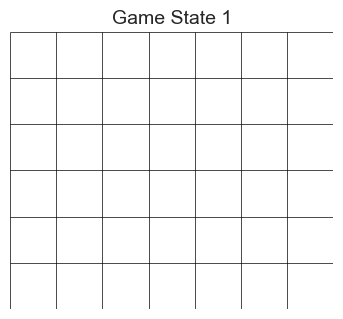

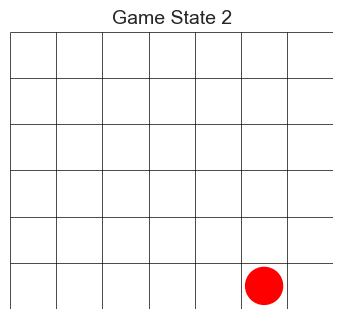

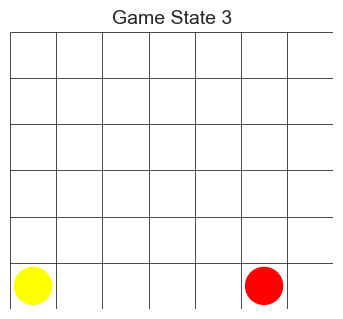

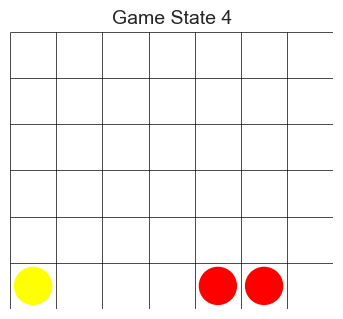

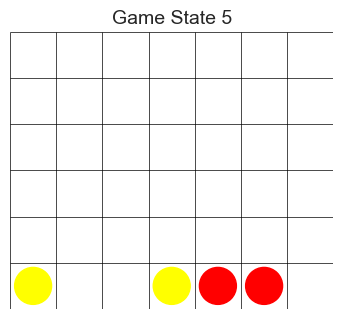

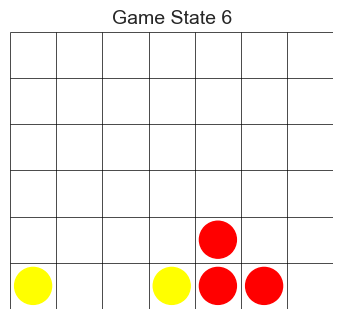

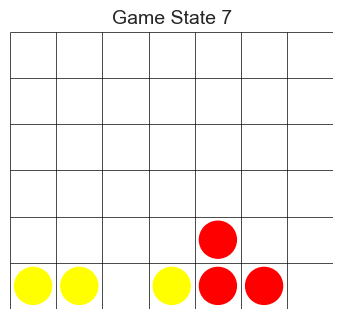

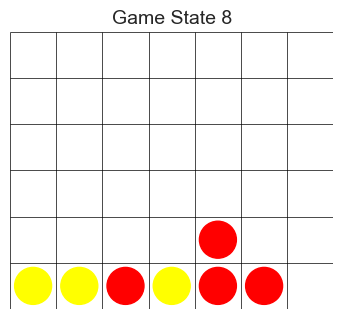

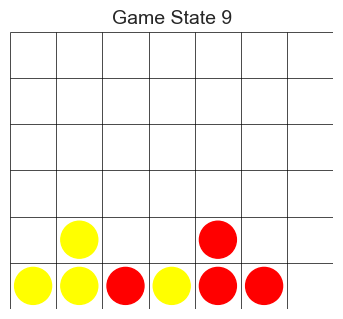

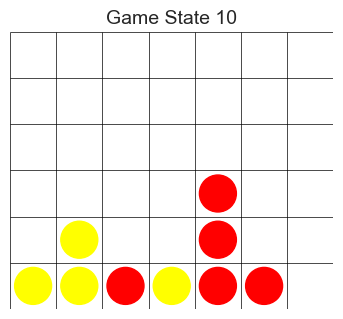

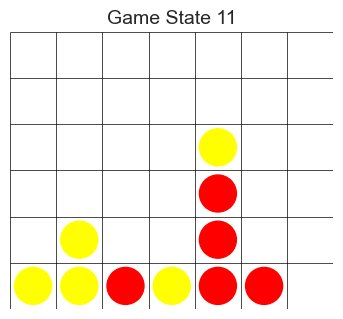

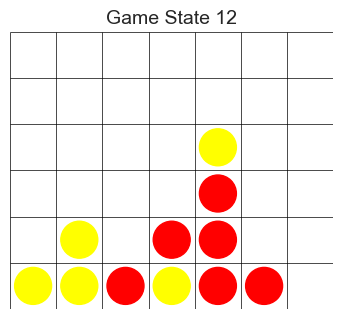

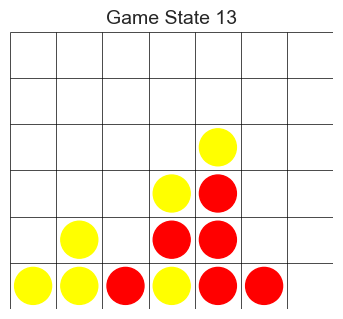

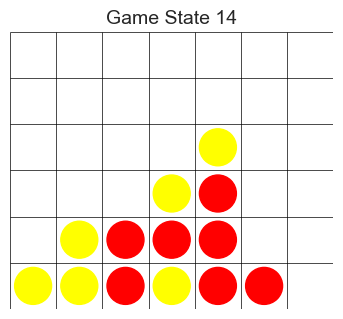

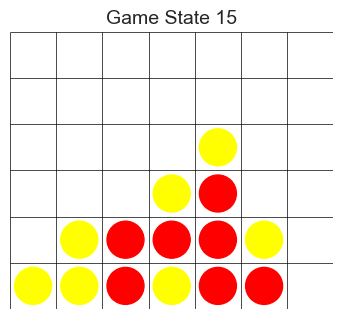

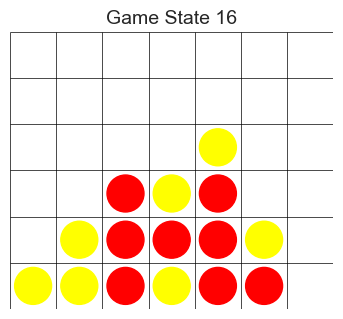

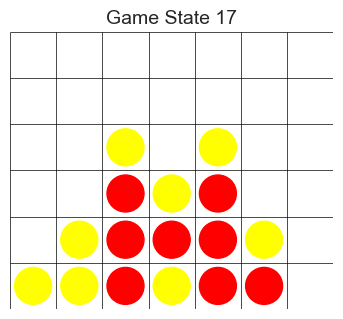

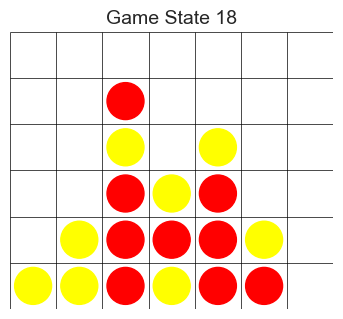

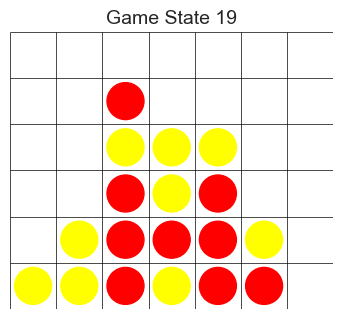

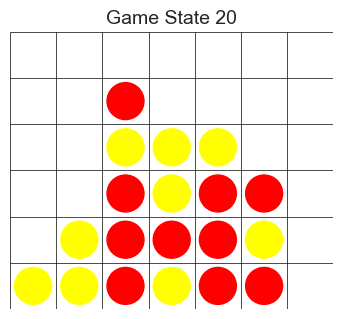

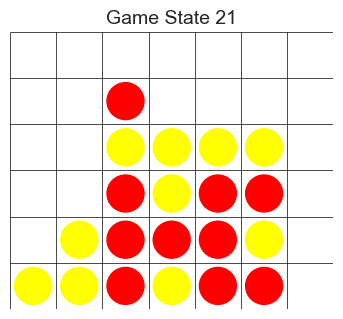

In [9]:
# Random Game
random_int = np.random.randint(0, len(data_df_1))
game = data_df_1.iloc[random_int]

# Or manual override game
game = data_df_1.iloc[59620]

# Grab the moves from this game and create a sequence of boards from those moves
boards = mt.Board.make_boards_from_moves(game.moves)

# Display the game unfolding:
print(f'Player 1: {game.player_one_id} vs Player 2: {game.player_two_id}. Winner: {game.winner_id}. (Game Int: {game.name})')

for board in boards:
    board.display_board()

# Reshape Data for CNN Input
Is there a more efficient way to do this sure. But this gets the job done and it's easier to parse I think.

In [10]:
data_df_1.head()

,game_id,player_one_id,player_two_id,winner_id,first_mover_id,moves,turns,start_time,end_time,player_one_win
0,1731877338926014-313026-dfd03d46,monte_carlo_50,monte_carlo_200,monte_carlo_200,monte_carlo_50,"[2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, ...",42,NaN,NaN,False
1,1731877383226884-899336-1e5dcfb5,random_naive,monte_carlo_500,monte_carlo_500,random_naive,"[3, 3, 6, 3, 1, 3, 2, 3]",8,NaN,NaN,False
2,1731877406489089-634971-504d60a5,random_not_stupid,random_naive,random_not_stupid,random_not_stupid,"[1, 2, 0, 2, 2, 0, 4, 0, 0, 5, 1, 3, 3, 4, 3, ...",17,NaN,NaN,True
3,1731877406489619-734997-a801c867,random_naive,random_not_stupid,random_not_stupid,random_naive,"[0, 2, 6, 5, 2, 6, 4, 4, 1, 1, 5, 1, 0, 2, 5, ...",28,NaN,NaN,False
4,1731877406489619-209807-735741d8,random_naive,monte_carlo_1000,monte_carlo_1000,random_naive,"[6, 3, 2, 3, 0, 3, 3, 2, 1, 1, 1, 0]",12,NaN,NaN,False


In [23]:

DISCOUNT_FACTOR = .9 
master_X = []
master_y = []

# for game in data_df_1.itertuples():
for game in data_df_1.iloc[:3].itertuples():    
    

    # Generate all of the board states for this game (Except for the initial blank slate)
    boards = mt.Board.make_boards_from_moves(game.moves)[1:]

    # From the boards, get a list of grids where the values are +1 for whoevers turn it is and -1 for the other player
    grids = [board.convert_to_plus_minus() for board in boards]

    # Reward assignment. If player 1 wins, the base reward will be +1 for all of player 1's moves and -1 for all of player 2's moves
    # If player 2 wins, the base reward will be -1 for all of player 1's moves and +1 for all of player 2's moves
    
    if game.player_one_win:
        p1_base_reward = 1
        p2_base_reward = -1
    else:
        p1_base_reward = -1
        p2_base_reward = 1
    
    # Player 1 always has odd moves, player 2 always has even moves. (But because we are 0 indexed, it will look like player 1 has even moves)
    p1_moves = [move for i, move in enumerate(game.moves) if i % 2 == 0]
    p2_moves = [move for i, move in enumerate(game.moves) if i % 2 == 1]

    # Calculate the rewards for each move
    p1_rewards = [p1_base_reward * DISCOUNT_FACTOR**i for i in range(len(p1_moves))][::-1]
    p2_rewards = [p2_base_reward * DISCOUNT_FACTOR**i for i in range(len(p2_moves))][::-1]


    print(f'Player 1 won: {game.player_one_win}')
    print(f'Moves: {game.moves}')
    print(f'Player 1 moves: {p1_moves}')
    print(f'Player 2 moves: {p2_moves}')

    print(f'Player 1 rewards: {p1_rewards}')
    print(f'Player 2 rewards: {p2_rewards}')


# Make sure both are actually numpy arrays and they are the same length


Player 1 won: False
Moves: [2, 5, 2, 4, 0, 3, 6, 2, 4, 3, 3, 5, 3, 5, 5, 1, 3, 3, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 5, 6, 5, 6, 6, 4, 4, 6, 6, 0, 0, 4, 4]
Player 1 moves: [2, 2, 0, 6, 4, 3, 3, 5, 3, 0, 0, 2, 1, 2, 2, 6, 6, 4, 6, 0, 4]
Player 2 moves: [5, 4, 3, 2, 3, 5, 5, 1, 3, 1, 0, 1, 1, 1, 5, 5, 6, 4, 6, 0, 4]
Player 1 rewards: [-0.12157665459056935, -0.13508517176729928, -0.15009463529699918, -0.16677181699666577, -0.18530201888518416, -0.20589113209464907, -0.2287679245496101, -0.2541865828329001, -0.2824295364810001, -0.31381059609000006, -0.3486784401000001, -0.3874204890000001, -0.4304672100000001, -0.4782969000000001, -0.531441, -0.5904900000000001, -0.6561, -0.7290000000000001, -0.81, -0.9, -1.0]
Player 2 rewards: [0.12157665459056935, 0.13508517176729928, 0.15009463529699918, 0.16677181699666577, 0.18530201888518416, 0.20589113209464907, 0.2287679245496101, 0.2541865828329001, 0.2824295364810001, 0.31381059609000006, 0.3486784401000001, 0.3874204890000001, 0.4304672100000001,

In [18]:
len(game.moves)

17

In [16]:
len(grids)

18

In [10]:
X = X.reshape(-1, 6, 7, 1)
X.shape

(1124067, 6, 7, 1)

## Check it

In [11]:
data_df_1.turns.iloc[0]

np.int64(42)

In [12]:
X[data_df_1.turns.iloc[0]-1]

array([[[ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.]],

       [[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]]])

## Split Dataset

In [12]:
# Train, validation, test split
from sklearn.model_selection import train_test_split

In [13]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-TRAIN_SIZE)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=TEST_SIZE)


# Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Infrastructure

In [15]:


# Define the CNN model
model = Sequential([
    # Input layer: (6, 7, 1)
    tf.keras.Input(shape=(6,7,1)),

    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 2D feature maps to a 1D vector
    Flatten(),

    # Fully connected (dense) layers
    Dense(128, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer: 7 neurons for columns (0-6)
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',  # Adaptive learning rate optimizer
              loss='sparse_categorical_crossentropy',  # For integer labels (0-6)
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 4, 5, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,847 (140.03 KB)

 Trainable params: 35,847 (140.03 KB)

 Non-trainable params: 0 (0.00 B)

## Training

array([6, 3, 4, ..., 2, 6, 2])

## Eval